# CNN + AvgPool
Try to improve CNN_264.

Change max pool to avg pool.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 20:21:53.028062


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = AveragePooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = AveragePooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 20:22:26.473056
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 average_pooling1d (AverageP  (None, 1246, 64)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 average_pooling1d_1 (Averag  (None, 308, 64)          0         
 ePooling1D)                 

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 20:22:26.836037
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 20:22:35.782978

Training # 1 1
2023-03-26 20:22:35.784426
2023-03-26 20:22:35.784483
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 20:22:36.985123


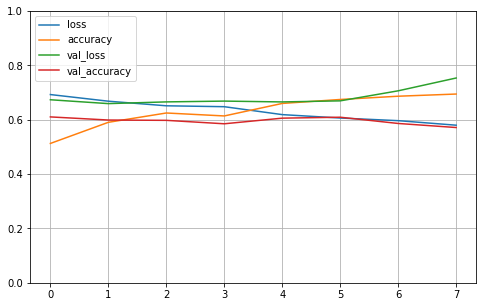


2023-03-26 20:23:19.624759

Testing # 1 1
2023-03-26 20:23:19.626176
2023-03-26 20:23:19.626524
PREDICT
2023-03-26 20:23:20.051914
Test 1:0 458:412 52.64%
Predict 1:0 263:607 30.23%
Test sizes (870, 4997) (870,)
Range of scores: 0.005894258 to 0.94963354
Score threshold 0.5
Confusion matrix
 [[323  89]
 [284 174]]
Normalized matrix
 [[0.37126437 0.10229885]
 [0.32643678 0.2       ]]


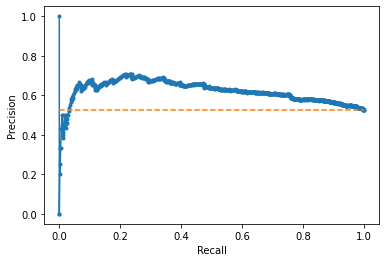

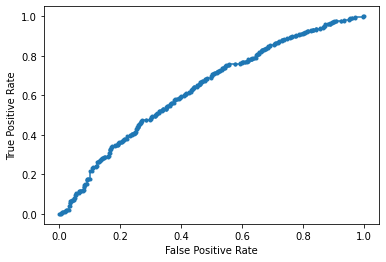

Accuracy: 57.13% Precision: 66.16% Recall: 37.99%
F1: 48.27% MCC: 0.1782
AUPRC: 62.06% AUROC: 63.44%
 accuracy [57.12643678160919]
 precision [66.15969581749049]
 recall [37.99126637554585]
 F1 [48.26629680998613]
 MCC [0.17818460750474444]
 AUPRC [62.061896079720405]
 AUROC [63.444906092339]
2023-03-26 20:23:21.412339

Training # 1 2
2023-03-26 20:23:21.412565
2023-03-26 20:23:21.412611
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 20:23:22.949047


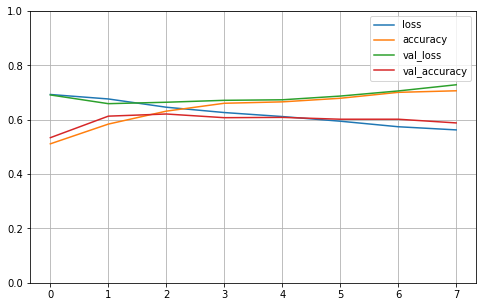


2023-03-26 20:23:44.714130

Testing # 1 2
2023-03-26 20:23:44.714425
2023-03-26 20:23:44.714465
PREDICT
2023-03-26 20:23:44.936578
Test 1:0 442:442 50.00%
Predict 1:0 482:402 54.52%
Test sizes (884, 4997) (884,)
Range of scores: 0.010662662 to 0.99895656
Score threshold 0.5
Confusion matrix
 [[240 202]
 [162 280]]
Normalized matrix
 [[0.27149321 0.22850679]
 [0.18325792 0.31674208]]


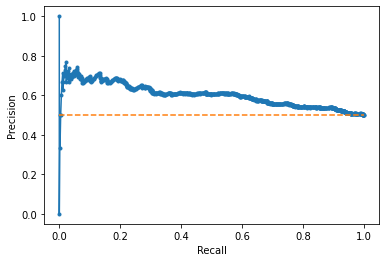

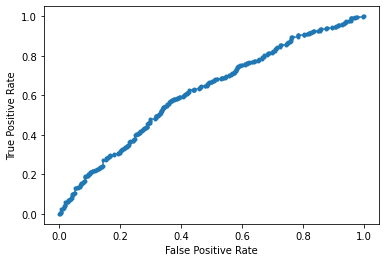

Accuracy: 58.82% Precision: 58.09% Recall: 63.35%
F1: 60.61% MCC: 0.1772
AUPRC: 60.12% AUROC: 61.89%
 accuracy [58.82352941176471]
 precision [58.09128630705395]
 recall [63.348416289592755]
 F1 [60.60606060606061]
 MCC [0.17719769041965552]
 AUPRC [60.116643713695424]
 AUROC [61.88652975983293]
2023-03-26 20:23:46.102987

Training # 1 3
2023-03-26 20:23:46.103209
2023-03-26 20:23:46.103255
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 20:23:48.306299


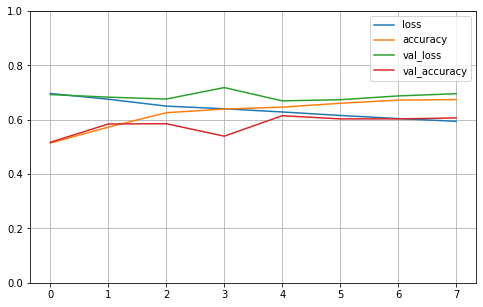


2023-03-26 20:24:10.567557

Testing # 1 3
2023-03-26 20:24:10.567645
2023-03-26 20:24:10.567678
PREDICT
2023-03-26 20:24:10.786271
Test 1:0 442:407 52.06%
Predict 1:0 556:293 65.49%
Test sizes (849, 4997) (849,)
Range of scores: 0.014014382 to 0.9901203
Score threshold 0.5
Confusion matrix
 [[183 224]
 [110 332]]
Normalized matrix
 [[0.2155477  0.26383981]
 [0.12956419 0.39104829]]


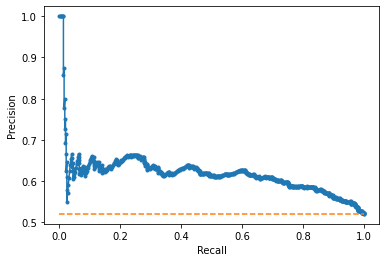

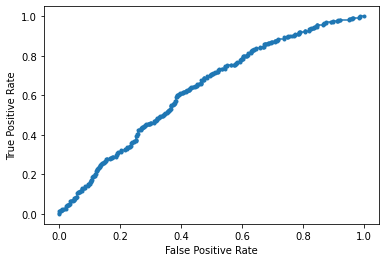

Accuracy: 60.66% Precision: 59.71% Recall: 75.11%
F1: 66.53% MCC: 0.2110
AUPRC: 61.85% AUROC: 63.06%
 accuracy [60.65959952885748]
 precision [59.71223021582733]
 recall [75.1131221719457]
 F1 [66.53306613226452]
 MCC [0.21096970669764314]
 AUPRC [61.84833949730646]
 AUROC [63.05935717700424]
2023-03-26 20:24:11.882997

Training # 1 4
2023-03-26 20:24:11.883946
2023-03-26 20:24:11.884003
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 20:24:13.908933


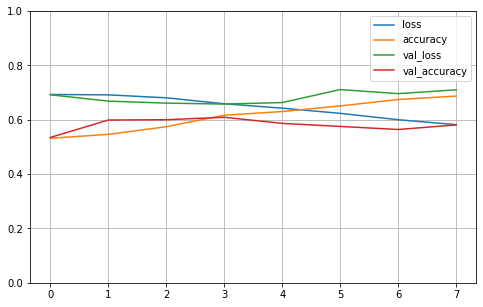


2023-03-26 20:24:28.359323

Testing # 1 4
2023-03-26 20:24:28.360801
2023-03-26 20:24:28.361176
PREDICT
2023-03-26 20:24:28.688080
Test 1:0 459:431 51.57%
Predict 1:0 460:430 51.69%
Test sizes (890, 4997) (890,)
Range of scores: 0.031577986 to 0.9754117
Score threshold 0.5
Confusion matrix
 [[244 187]
 [186 273]]
Normalized matrix
 [[0.2741573  0.21011236]
 [0.20898876 0.30674157]]


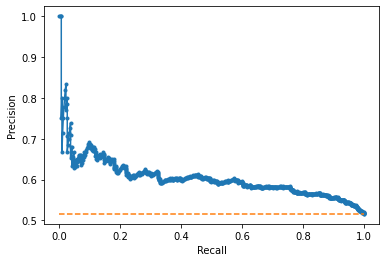

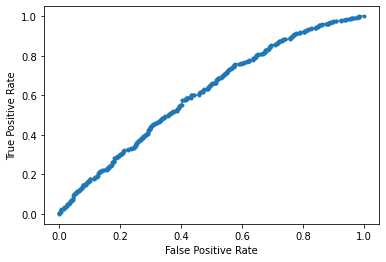

Accuracy: 58.09% Precision: 59.35% Recall: 59.48%
F1: 59.41% MCC: 0.1609
AUPRC: 60.42% AUROC: 61.18%
 accuracy [58.08988764044943]
 precision [59.34782608695652]
 recall [59.47712418300654]
 F1 [59.41240478781283]
 MCC [0.16090832616169123]
 AUPRC [60.41663905758507]
 AUROC [61.18314301745447]
2023-03-26 20:24:29.653356

Training # 1 5
2023-03-26 20:24:29.653520
2023-03-26 20:24:29.653566
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 20:24:30.814301


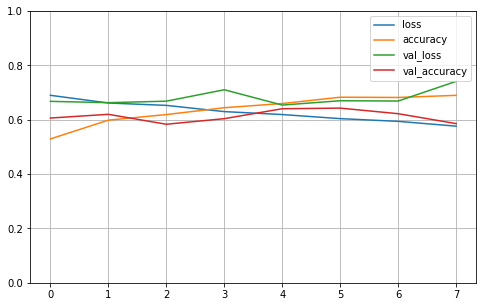


2023-03-26 20:24:52.632221

Testing # 1 5
2023-03-26 20:24:52.633599
2023-03-26 20:24:52.633925
PREDICT
2023-03-26 20:24:53.054121
Test 1:0 457:419 52.17%
Predict 1:0 236:640 26.94%
Test sizes (876, 4997) (876,)
Range of scores: 0.003060101 to 0.9703581
Score threshold 0.5
Confusion matrix
 [[348  71]
 [292 165]]
Normalized matrix
 [[0.39726027 0.08105023]
 [0.33333333 0.18835616]]


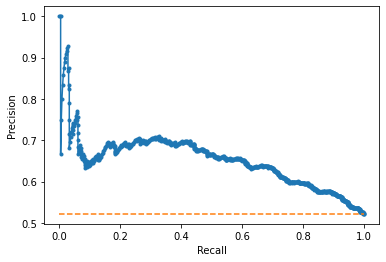

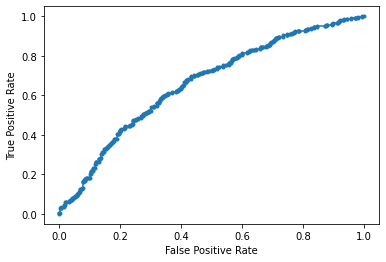

Accuracy: 58.56% Precision: 69.92% Recall: 36.11%
F1: 47.62% MCC: 0.2157
AUPRC: 65.28% AUROC: 66.08%
 accuracy [58.56164383561644]
 precision [69.91525423728814]
 recall [36.10503282275711]
 F1 [47.61904761904761]
 MCC [0.21573118915007022]
 AUPRC [65.27649470775665]
 AUROC [66.08419546382707]
2023-03-26 20:24:54.313844

Training # 2 1
2023-03-26 20:24:54.315721
2023-03-26 20:24:54.316078
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 20:24:55.659430


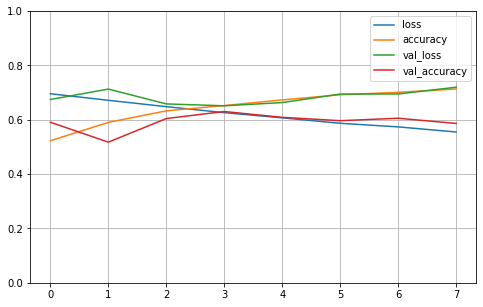


2023-03-26 20:25:09.342651

Testing # 2 1
2023-03-26 20:25:09.342752
2023-03-26 20:25:09.342788
PREDICT
2023-03-26 20:25:09.568370
Test 1:0 472:415 53.21%
Predict 1:0 433:454 48.82%
Test sizes (887, 4997) (887,)
Range of scores: 0.0065284194 to 0.9898303
Score threshold 0.5
Confusion matrix
 [[251 164]
 [203 269]]
Normalized matrix
 [[0.28297632 0.1848929 ]
 [0.22886133 0.30326945]]


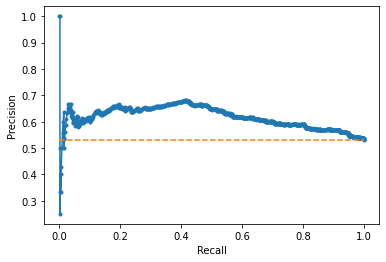

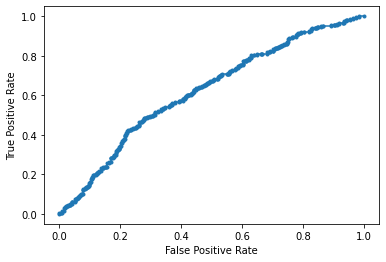

Accuracy: 58.62% Precision: 62.12% Recall: 56.99%
F1: 59.45% MCC: 0.1744
AUPRC: 61.75% AUROC: 62.24%
 accuracy [58.62457722660653]
 precision [62.12471131639723]
 recall [56.99152542372882]
 F1 [59.4475138121547]
 MCC [0.17442226128584082]
 AUPRC [61.74846197547317]
 AUROC [62.24218909536451]
2023-03-26 20:25:10.602442

Training # 2 2
2023-03-26 20:25:10.602637
2023-03-26 20:25:10.604496
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 20:25:11.788915


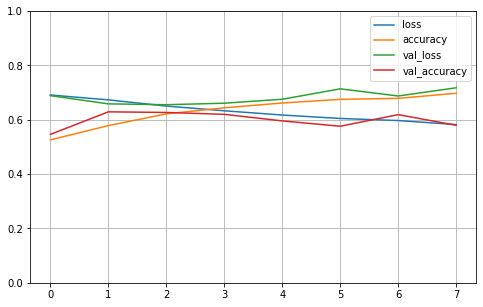


2023-03-26 20:25:33.565408

Testing # 2 2
2023-03-26 20:25:33.565503
2023-03-26 20:25:33.565536
PREDICT
2023-03-26 20:25:33.786851
Test 1:0 452:416 52.07%
Predict 1:0 293:575 33.76%
Test sizes (868, 4997) (868,)
Range of scores: 0.019705987 to 0.96320385
Score threshold 0.5
Confusion matrix
 [[313 103]
 [262 190]]
Normalized matrix
 [[0.36059908 0.11866359]
 [0.30184332 0.21889401]]


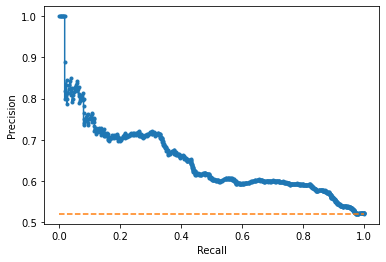

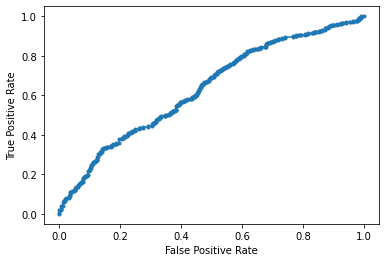

Accuracy: 57.95% Precision: 64.85% Recall: 42.04%
F1: 51.01% MCC: 0.1825
AUPRC: 64.92% AUROC: 63.51%
 accuracy [57.94930875576036]
 precision [64.84641638225256]
 recall [42.0353982300885]
 F1 [51.006711409395976]
 MCC [0.1825096728307781]
 AUPRC [64.92127456820411]
 AUROC [63.50621170864533]
2023-03-26 20:25:34.934824

Training # 2 3
2023-03-26 20:25:34.935009
2023-03-26 20:25:34.935056
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 20:25:36.104046


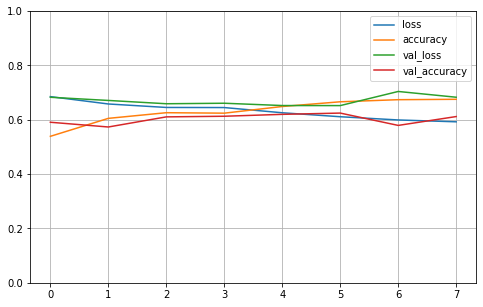


2023-03-26 20:25:50.163793

Testing # 2 3
2023-03-26 20:25:50.163904
2023-03-26 20:25:50.163941
PREDICT
2023-03-26 20:25:50.382469
Test 1:0 453:407 52.67%
Predict 1:0 383:477 44.53%
Test sizes (860, 4997) (860,)
Range of scores: 0.029178124 to 0.97800046
Score threshold 0.5
Confusion matrix
 [[275 132]
 [202 251]]
Normalized matrix
 [[0.31976744 0.15348837]
 [0.23488372 0.29186047]]


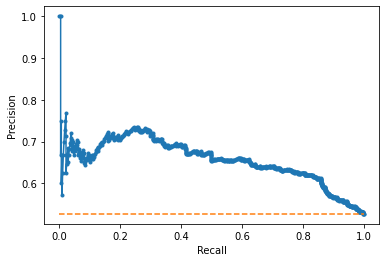

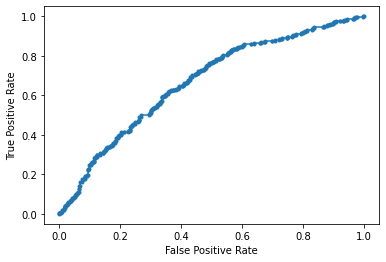

Accuracy: 61.16% Precision: 65.54% Recall: 55.41%
F1: 60.05% MCC: 0.2308
AUPRC: 65.66% AUROC: 66.77%
 accuracy [61.16279069767442]
 precision [65.53524804177546]
 recall [55.40838852097131]
 F1 [60.04784688995216]
 MCC [0.23081356115952123]
 AUPRC [65.65624435805701]
 AUROC [66.7708045191489]
2023-03-26 20:25:51.301771

Training # 2 4
2023-03-26 20:25:51.302896
2023-03-26 20:25:51.302947
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 20:25:52.468645


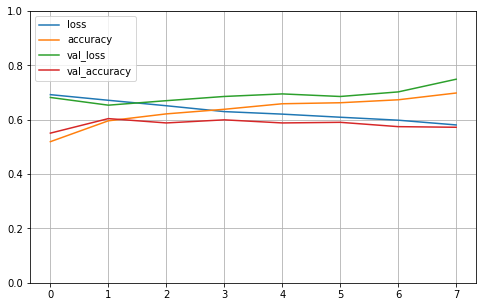


2023-03-26 20:26:06.570757

Testing # 2 4
2023-03-26 20:26:06.570854
2023-03-26 20:26:06.570889
PREDICT
2023-03-26 20:26:06.784475
Test 1:0 432:447 49.15%
Predict 1:0 334:545 38.00%
Test sizes (879, 4997) (879,)
Range of scores: 0.006232541 to 0.9960288
Score threshold 0.5
Confusion matrix
 [[308 139]
 [237 195]]
Normalized matrix
 [[0.35039818 0.15813424]
 [0.26962457 0.221843  ]]


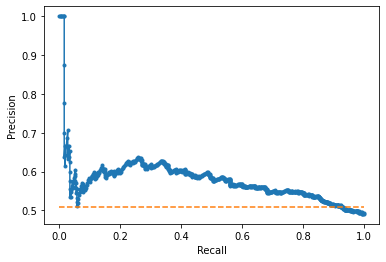

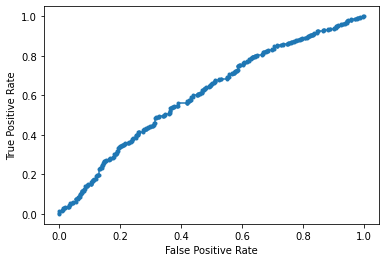

Accuracy: 57.22% Precision: 58.38% Recall: 45.14%
F1: 50.91% MCC: 0.1446
AUPRC: 57.82% AUROC: 60.75%
 accuracy [57.22411831626849]
 precision [58.38323353293413]
 recall [45.13888888888889]
 F1 [50.91383812010444]
 MCC [0.14463537355472905]
 AUPRC [57.82040090196821]
 AUROC [60.746540724169364]
2023-03-26 20:26:07.709661

Training # 2 5
2023-03-26 20:26:07.710756
2023-03-26 20:26:07.710822
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 20:26:08.908332


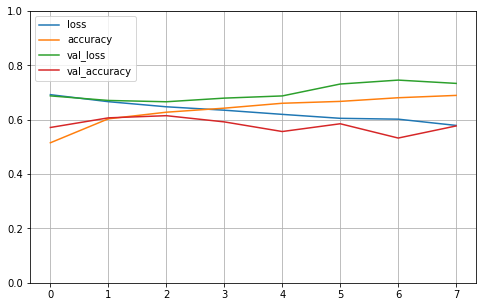


2023-03-26 20:26:31.074369

Testing # 2 5
2023-03-26 20:26:31.074473
2023-03-26 20:26:31.074509
PREDICT
2023-03-26 20:26:31.302021
Test 1:0 449:426 51.31%
Predict 1:0 475:400 54.29%
Test sizes (875, 4997) (875,)
Range of scores: 0.014861903 to 0.9912815
Score threshold 0.5
Confusion matrix
 [[228 198]
 [172 277]]
Normalized matrix
 [[0.26057143 0.22628571]
 [0.19657143 0.31657143]]


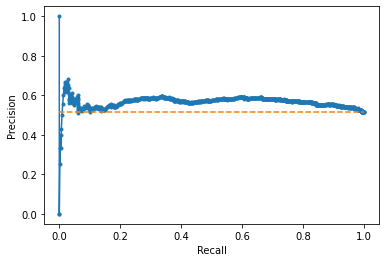

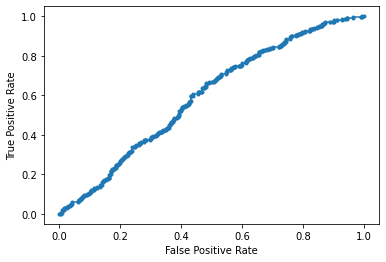

Accuracy: 57.71% Precision: 58.32% Recall: 61.69%
F1: 59.96% MCC: 0.1526
AUPRC: 56.56% AUROC: 59.46%
 accuracy [57.714285714285715]
 precision [58.31578947368421]
 recall [61.69265033407573]
 F1 [59.956709956709965]
 MCC [0.15264698067143403]
 AUPRC [56.56266458699577]
 AUROC [59.463910411242516]
2023-03-26 20:26:31.944369


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.59% std 1.35
 precision mean 62.24% std 4.14
 recall mean 53.33% std 12.59
 F1 mean 56.38% std 6.39
 MCC mean 0.18% std 0.03
 AUPRC mean 61.64% std 3.06
 AUROC mean 62.84% std 2.28
 accuracy [[57.12643678160919], [58.82352941176471], [60.65959952885748], [58.08988764044943], [58.56164383561644], [58.62457722660653], [57.94930875576036], [61.16279069767442], [57.22411831626849], [57.714285714285715]]
 precision [[66.15969581749049], [58.09128630705395], [59.71223021582733], [59.34782608695652], [69.91525423728814], [62.12471131639723], [64.84641638225256], [65.53524804177546], [58.38323353293413], [58.31578947368421]]
 recall [[37.99126637554585], [63.348416289592755], [75.1131221719457], [59.47712418300654], [36.10503282275711], [56.99152542372882], [42.0353982300885], [55.40838852097131], [45.13888888888889], [61.69265033407573]]
 F1 [[48.26629680998613], [60.60606060606061], [66.53306613226452], [59.41240478781283], [47.61904761904761], [59.4475138121547], [51.00671